# Torino Neighborhood

## Appliad Data Science Capstone Project : IBM Course on Coursera

### Importing Libraries

In [403]:
import pandas as pd
import numpy as np
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import requests # library to handle requests
import matplotlib.pyplot as plt
from sklearn import linear_model
import math

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print("All Libraries are loaded")

All Libraries are loaded


### Data Retriving and Wrangling

#### Retriving Neighborhood postion data from existing csv file

In [407]:
df=pd.read_csv('TorinoNeighborhood.csv', header=0)

In [408]:
df.head()

,Borhood,Neighborhood,Latitude,Longitude
0,1,Centro,45.071200,7.685400
1,1,Crocetta,45.057700,7.662500
2,2,Santa Rita,45.046800,7.646100
3,2,Mirafiori Nord,45.040351,7.628422
4,2,Mirafiori Sud,45.017828,7.632849


##### The dataset has the structure borhoood, neighborhood, latitude and longitude of the borhood

#### Retriving Population data from 2007 to 2018 from existing csv file and merge it with the neighborhood dataset 

In [409]:
df_pop=pd.read_csv('popolazionetorino2007-2018.csv', header=0)

##### We can see that the data are organized for borhood and not for neighborhood: lets' split the population data between neighborhood supposing that the population is distributed unformely, unfortunatelly it was not possible to find population data organized per neighborhood

In [410]:
#create correspondence with number of neighborhood for each borhood
df_number_neighborhood=df.groupby('Borhood').size().reset_index()
df_number_neighborhood.columns = ["Borhood", "Number of Neighborhood"]

#splitting the df_pop dataframe in to neighborhood
for i in range(0, df_pop.shape[0]):
    df_pop.loc[i]=df_pop.loc[i]/df_number_neighborhood.loc[i][1]
    df_pop.loc[i,'Borhood']=i+1

In [411]:
df= pd.merge(df, df_pop)
df.iloc[:,4:17] = df.iloc[:,4:17].astype(int)

#### Retriving Foreigners Population data

In [412]:
df_fr_2016=pd.read_excel('E22016.xlsx', header=0) # reading file
df_fr_2016.drop(df.index[:5], inplace=True) # drop first rows with the title
df_fr_2016.drop(df.index[28:31], inplace=True) # drop last rows with the total
df_fr_2016.columns=["Neighborhood","Female","Male","f2016"] # add column name
df_fr_2016= df_fr_2016.drop(columns="Female") # drop Female partial data
df_fr_2016= df_fr_2016.drop(columns="Male") #drop male partial data
df_fr_2016['Neighborhood'] = df_fr_2016['Neighborhood'].str.replace('\d+\.+', '') #cleanup the name of the Neighborhood
df_fr_2016=df_fr_2016.reset_index(drop=True) #reset index

##### Population data are only available between 2017-2019 and are in three differente xlsx file. Let's load in dataframe, clean it and merge together

In [413]:
#repat the above code
df_fr_2017=pd.read_excel('E22017.xlsx', header=0)
df_fr_2017.drop(df.index[:5], inplace=True)
df_fr_2017.drop(df.index[28:31], inplace=True)
df_fr_2017.drop(df_fr_2017.columns[len(df_fr_2017.columns)-1], axis=1, inplace=True)
df_fr_2017.drop(df_fr_2017.columns[len(df_fr_2017.columns)-1], axis=1, inplace=True)
df_fr_2017.columns=["Neighborhood","Female","Male","f2017"]
df_fr_2017= df_fr_2017.drop(columns="Female")
df_fr_2017= df_fr_2017.drop(columns="Male")
df_fr_2017['Neighborhood'] = df_fr_2017['Neighborhood'].str.replace('\d+\.+', '')
df_fr_2017=df_fr_2017.reset_index(drop=True)

In [414]:
df_fr_2018=pd.read_excel('E22018.xls', header=0)
df_fr_2018.drop(df.index[:5], inplace=True)
df_fr_2018.drop(df.index[28:31], inplace=True)
df_fr_2018.columns=["Neighborhood","Female","Male","f2018"]
df_fr_2018= df_fr_2018.drop(columns="Female")
df_fr_2018= df_fr_2018.drop(columns="Male")
df_fr_2018['Neighborhood'] = df_fr_2018['Neighborhood'].str.replace('\d+\.+', '')
df_fr_2018=df_fr_2018.reset_index(drop=True)

In [415]:
#Merge all the foreigners data
df_fr= pd.merge(df_fr_2016, df_fr_2017)
df_fr=pd.merge(df_fr, df_fr_2018)

In [416]:
df_fr['Neighborhood']=df_fr['Neighborhood'].astype(str)

#### Merge all the data foreigners and overall population, as well as the Neigbhorhood, in a single dataframe

In [417]:
df_full=pd.merge(df_fr,df,on='Neighborhood', how="right")

In [418]:
# For Value with NAN it is used the mean of all the foreign of that year of the other Neighborhood
df_full['f2016'].fillna((df_full['f2016'].mean()), inplace=True)
df_full['f2017'].fillna((df_full['f2017'].mean()), inplace=True)
df_full['f2018'].fillna((df_full['f2018'].mean()), inplace=True)
df_full['f2016']=df_full['f2016'].astype(int)
df_full['f2017']=df_full['f2017'].astype(int)
df_full['f2018']=df_full['f2018'].astype(int) 

In [419]:
address = 'Torino'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of  are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of  are 45.0677551, 7.6824892.


In [420]:
df_full.head()

,Neighborhood,f2016,f2017,f2018,Borhood,Latitude,Longitude,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Centro,5216,5402,5363,1,45.071200,7.685400,40030,39906,39804,39589,39261,39476,39012,39265,39265,39526,39657,39523
1,San Salvario,5474,5197,4874,8,45.054950,7.680152,22543,22526,22499,22412,22338,22475,22213,21970,21822,21660,21505,21263
2,Crocetta,3190,3180,3135,1,45.057700,7.662500,40030,39906,39804,39589,39261,39476,39012,39265,39265,39526,39657,39523
3,San Paolo,4488,4408,4314,3,45.061463,7.645838,26256,26282,26294,26222,26141,26085,25882,25675,25412,25259,25088,24906
4,Cenisia,5252,5032,4802,3,45.069707,7.649879,26256,26282,26294,26222,26141,26085,25882,25675,25412,25259,25088,24906


### Data Visualization

### Train and Predict data to finde forecast for population in 2019 and 2020

In [421]:
df_temp=df_full[df_full['Neighborhood']=='Centro'][['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']]

df_temp=df_temp.transpose()

df_temp=df_temp.reset_index()
df_temp.columns=['Year','Population']
df_temp['Year']=df_temp['Year'].astype(int)

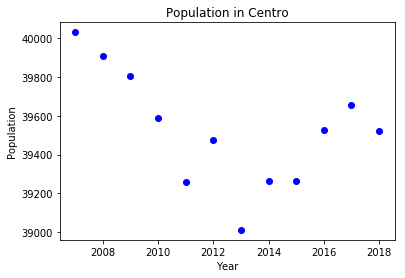

In [422]:
plt.scatter(df_temp.Year, df_temp.Population,  color='blue')
plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Population in "+ 'Centro')

plt.show()

##### This Graph shows that the population is decreasing in "CENTRO" Neighborhood. Let's now construct a model that will evaluate the possible population in 2019 and 2020

In [423]:
regr = linear_model.LinearRegression()
x = np.asanyarray(df_temp[['Year']])
y = np.asanyarray(df_temp[['Population']])
regr.fit (x, y)

#Prediction of 2019 and 2020 population
y_prd_2019 = regr.predict([[2019]]).astype(int)
y_prd_2020 = regr.predict([[2020]]).astype(int)
df_temp=df_temp.append({'Year':2019, 'Population':y_prd_2019[0][0]} , ignore_index=True)
df_temp=df_temp.append({'Year':2020, 'Population':y_prd_2020[0][0]} , ignore_index=True)

Text(0, 0.5, 'Population in Centro')

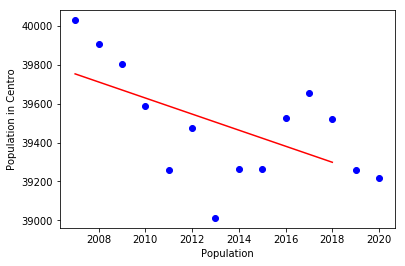

In [424]:
plt.scatter(df_temp.Year, df_temp.Population,  color='blue')
plt.plot(x, regr.coef_[0][0]*x + regr.intercept_[0], '-r')
plt.xlabel("Population")
plt.ylabel("Population in "+ 'Centro')

##### Let's generalize the model for all our data

In [425]:
df_full['2019']=' '
df_full['2020']=' '
pd.options.mode.chained_assignment = None  # default='warn'


for i in range(0, df_full.shape[0]):
    df_temp=df_full[df_full['Neighborhood']==df_full['Neighborhood'][i]][['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']]
    df_temp=df_temp.transpose()
    df_temp=df_temp.reset_index()
    df_temp.columns=['Year','Population']
    df_temp['Year']=df_temp['Year'].astype(int)
    regr = linear_model.LinearRegression()
    x = np.asanyarray(df_temp[['Year']])
    y = np.asanyarray(df_temp[['Population']])
    regr.fit (x, y)
    y_prd_2019 = regr.predict([[2019]]).astype(int)
    y_prd_2020 = regr.predict([[2020]]).astype(int)
    df_full['2019'][i]=y_prd_2019[0][0]
    df_full['2020'][i]=y_prd_2020[0][0]


In [426]:
df_full.head()

,Neighborhood,f2016,f2017,f2018,Borhood,Latitude,Longitude,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Centro,5216,5402,5363,1,45.071200,7.685400,40030,39906,39804,...,39261,39476,39012,39265,39265,39526,39657,39523,39257,39215
1,San Salvario,5474,5197,4874,8,45.054950,7.680152,22543,22526,22499,...,22338,22475,22213,21970,21822,21660,21505,21263,21341,21224
2,Crocetta,3190,3180,3135,1,45.057700,7.662500,40030,39906,39804,...,39261,39476,39012,39265,39265,39526,39657,39523,39257,39215
3,San Paolo,4488,4408,4314,3,45.061463,7.645838,26256,26282,26294,...,26141,26085,25882,25675,25412,25259,25088,24906,24917,24782
4,Cenisia,5252,5032,4802,3,45.069707,7.649879,26256,26282,26294,...,26141,26085,25882,25675,25412,25259,25088,24906,24917,24782


##### Integrating with foreigners data

In [427]:
df_full['f2019']=' '
df_full['f2020']=' '

for i in range(0, df_full.shape[0]):
    df_temp=df_full[df_full['Neighborhood']==df_full['Neighborhood'][0]][['f2016','f2017','f2018']]
    df_temp=df_temp.transpose()
    df_temp=df_temp.reset_index()
    df_temp.columns=['Year','Population']
    df_temp['Year'][0]=2016
    df_temp['Year'][1]=2017
    df_temp['Year'][2]=2018
    df_temp['Year']=df_temp['Year'].astype(int)
    regr = linear_model.LinearRegression()
    x = np.asanyarray(df_temp[['Year']])
    y = np.asanyarray(df_temp[['Population']])
    regr.fit (x, y)
    y_prd_2019 = regr.predict([[2019]]).astype(int)
    y_prd_2020 = regr.predict([[2020]]).astype(int)
    df_full['f2019'][i]=y_prd_2019[0][0]
    df_full['f2020'][i]=y_prd_2020[0][0]

In [428]:
df_full.head()

,Neighborhood,f2016,f2017,f2018,Borhood,Latitude,Longitude,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,f2019,f2020
0,Centro,5216,5402,5363,1,45.071200,7.685400,40030,39906,39804,...,39012,39265,39265,39526,39657,39523,39257,39215,5474,5547
1,San Salvario,5474,5197,4874,8,45.054950,7.680152,22543,22526,22499,...,22213,21970,21822,21660,21505,21263,21341,21224,5474,5547
2,Crocetta,3190,3180,3135,1,45.057700,7.662500,40030,39906,39804,...,39012,39265,39265,39526,39657,39523,39257,39215,5474,5547
3,San Paolo,4488,4408,4314,3,45.061463,7.645838,26256,26282,26294,...,25882,25675,25412,25259,25088,24906,24917,24782,5474,5547
4,Cenisia,5252,5032,4802,3,45.069707,7.649879,26256,26282,26294,...,25882,25675,25412,25259,25088,24906,24917,24782,5474,5547


<p> At this point our dataset has the following information: 
name of the neighborhood
name of the Borhood
latitude and longitude of the neighborhood
all the growth in population between 2007 and 2020 per Borhood,
all the Foreigners population between 2016 and 2020
</p>

#### Printing a Map of the City showing the position of the different Neighborhood

In [429]:
# create map of Torino using latitude and longitude values
map_torino = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df_full['Latitude'], df_full['Longitude'], df_full['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_torino)  
    
map_torino

### Define FourSquare Credentials

In [430]:
CLIENT_ID = 'M2VPCBCESS5F1WSBHKU03H01LZLYHGHEP4O5BDM3KRV35OGN' # your Foursquare ID
CLIENT_SECRET = 'XPAZXSCGGQE4QELU3L5ARQZM5HYJWGWZJPVP3FBQDGBAQZNI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M2VPCBCESS5F1WSBHKU03H01LZLYHGHEP4O5BDM3KRV35OGN
CLIENT_SECRET:XPAZXSCGGQE4QELU3L5ARQZM5HYJWGWZJPVP3FBQDGBAQZNI


### Retrive Torino Venues From FourSquare

In [431]:
# Writing of function to get venues near 500m
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [432]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
torino_venues = getNearbyVenues(names=df_full['Neighborhood'],
                                   latitudes=df_full['Latitude'],
                                   longitudes=df_full['Longitude']
                                  )


Centro
San Salvario
Crocetta
San Paolo
Cenisia
San Donato
Aurora
Vanchiglia
Santa Rita
Mirafiori Nord
Pozzo Strada
Parella
Le Vallette
Madonna di Campagna
Borgata Vittoria
Barriera di Milano
Falchera
Regio Parco
Madonna del Pilone
Mirafiori Sud
Cit Turin
Borgata Lesna
Campidoglio
Barriera di Lanzo
Lucento
Barca
Bertolla
Rebaudengo
Villaretto
Famolenta
Borgata Sassi
Cavoretto
Borgo Po
Nizza Millefonti
Lingotto
Filadelfia


In [433]:
torino_restaurant.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Aurora,7,7,7,7,7,7
Barca,2,2,2,2,2,2
Barriera di Lanzo,4,4,4,4,4,4
Barriera di Milano,2,2,2,2,2,2
Bertolla,1,1,1,1,1,1
Borgata Lesna,2,2,2,2,2,2
Borgata Sassi,4,4,4,4,4,4
Borgata Vittoria,1,1,1,1,1,1
Borgo Po,9,9,9,9,9,9


In [434]:
torino_venues[torino_venues['Neighborhood']=='Barriera di Milano']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
392,Barriera di Milano,45.092388,7.69532,Mercato di Piazza Foroni,45.089987,7.695532,Market
393,Barriera di Milano,45.092388,7.69532,Laboratori di Barriera,45.091437,7.690012,Community Center
394,Barriera di Milano,45.092388,7.69532,Pizzeria Cristina,45.088313,7.693226,Pizza Place
395,Barriera di Milano,45.092388,7.69532,Fermata 232 - Palermo,45.090901,7.692812,Bus Stop
396,Barriera di Milano,45.092388,7.69532,Animalcity,45.090183,7.692345,Pet Store
397,Barriera di Milano,45.092388,7.69532,Alla Portata,45.093726,7.690700,Pizza Place


In [435]:
torino_restaurant = torino_venues[torino_venues["Venue Category"].str.contains('Restaurant') | torino_venues["Venue Category"].str.contains('Pizza')]

In [436]:
print('There are {} uniques Restaurants.'.format(len(torino_restaurant['Venue Category'].unique()))) #unique categories

There are 31 uniques Restaurants.


In [437]:
# one hot encoding
torino_onehot = pd.get_dummies(torino_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
torino_onehot['Neighborhood'] = torino_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [torino_onehot.columns[-1]] + list(torino_onehot.columns[:-1])
torino_onehot = torino_onehot[fixed_columns]

In [438]:
torino_grouped = torino_onehot.groupby('Neighborhood').mean().reset_index()
torino_grouped.head()

,Neighborhood,Abruzzo Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant,Eastern European Restaurant,Emilia Restaurant,...,Moroccan Restaurant,Peruvian Restaurant,Piedmontese Restaurant,Pizza Place,Restaurant,Roman Restaurant,Seafood Restaurant,Sicilian Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant
0,Aurora,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.0,0.0,...,0.142857,0.0,0.142857,0.0,0.142857,0.0,0.0,0.0,0.0,0.0
1,Barca,0.0,0.0,0.0,0.5,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,Barriera di Lanzo,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,...,0.000000,0.0,0.000000,0.5,0.000000,0.0,0.0,0.0,0.0,0.0
3,Barriera di Milano,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,Bertolla,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [439]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [440]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = torino_grouped['Neighborhood']

for ind in np.arange(torino_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(torino_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aurora,Chinese Restaurant,Italian Restaurant,Restaurant,Piedmontese Restaurant,Moroccan Restaurant,French Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Emilia Restaurant,Eastern European Restaurant
1,Barca,Asian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,American Restaurant,Argentinian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant,Eastern European Restaurant
2,Barriera di Lanzo,Pizza Place,Italian Restaurant,Chinese Restaurant,Indian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Eastern European Restaurant
3,Barriera di Milano,Pizza Place,Vegetarian / Vegan Restaurant,Indian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant,Eastern European Restaurant
4,Bertolla,Pizza Place,Vegetarian / Vegan Restaurant,Indian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant,Eastern European Restaurant


### Cluster The Neighborhood

In [441]:
# set number of clusters
kclusters = 6

torino_grouped_clustering = torino_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(torino_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [442]:
df_merged = df_full

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_merged.head() # check the last columns!

,Neighborhood,f2016,f2017,f2018,Borhood,Latitude,Longitude,2007,2008,2009,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centro,5216,5402,5363,1,45.071200,7.685400,40030,39906,39804,...,Italian Restaurant,Pizza Place,Piedmontese Restaurant,Japanese Restaurant,Argentinian Restaurant,Kebab Restaurant,Ligurian Restaurant,Vegetarian / Vegan Restaurant,Sicilian Restaurant,Restaurant
1,San Salvario,5474,5197,4874,8,45.054950,7.680152,22543,22526,22499,...,Pizza Place,Italian Restaurant,French Restaurant,Seafood Restaurant,Argentinian Restaurant,Piedmontese Restaurant,Kebab Restaurant,Ethiopian Restaurant,Indian Restaurant,Asian Restaurant
2,Crocetta,3190,3180,3135,1,45.057700,7.662500,40030,39906,39804,...,Pizza Place,Restaurant,Italian Restaurant,Sushi Restaurant,Indian Restaurant,Asian Restaurant,Argentinian Restaurant,Brazilian Restaurant,German Restaurant,Chinese Restaurant
3,San Paolo,4488,4408,4314,3,45.061463,7.645838,26256,26282,26294,...,Pizza Place,Japanese Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Italian Restaurant,Restaurant,Roman Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant
4,Cenisia,5252,5032,4802,3,45.069707,7.649879,26256,26282,26294,...,Italian Restaurant,Sushi Restaurant,Asian Restaurant,Japanese Restaurant,Pizza Place,Piedmontese Restaurant,Peruvian Restaurant,French Restaurant,Chinese Restaurant,Kebab Restaurant


In [443]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], tiles="OpenStreetMap", zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


In [444]:
df_merged=df_merged.dropna(axis=0)
df_merged['Cluster Labels'].value_counts() # check the last columns!

1.0    10
2.0    10
3.0     4
0.0     3
5.0     2
4.0     2
Name: Cluster Labels, dtype: int64

In [445]:
df_merged['Cluster Labels'] = df_merged['Cluster Labels'].astype(int)

In [446]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)

In [447]:
map_clusters

### Examine The Cluster

In [448]:
df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]].head()

,f2016,Latitude,Longitude,2007,2008,2009,2010,2011,2012,2013,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,13446,45.082574,7.686009,22164,22306,22321,22341,22362,22561,22374,...,Chinese Restaurant,Italian Restaurant,Restaurant,Piedmontese Restaurant,Moroccan Restaurant,French Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Emilia Restaurant,Eastern European Restaurant
13,7218,45.100819,7.668450,25093,25217,25358,25356,25333,25515,25348,...,Chinese Restaurant,Pizza Place,Italian Restaurant,Abruzzo Restaurant,Roman Restaurant,German Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant
27,5988,45.104257,7.699304,13286,13322,13415,13382,13421,13556,13536,...,Chinese Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Eastern European Restaurant,Emilia Restaurant


In [449]:
df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]].head()

,f2016,Latitude,Longitude,2007,2008,2009,2010,2011,2012,2013,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,3190,45.057700,7.662500,40030,39906,39804,39589,39261,39476,39012,...,Pizza Place,Restaurant,Italian Restaurant,Sushi Restaurant,Indian Restaurant,Asian Restaurant,Argentinian Restaurant,Brazilian Restaurant,German Restaurant,Chinese Restaurant
3,4488,45.061463,7.645838,26256,26282,26294,26222,26141,26085,25882,...,Pizza Place,Japanese Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Italian Restaurant,Restaurant,Roman Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant
5,8624,45.082361,7.661787,32535,32737,32783,32852,32929,33259,33062,...,Pizza Place,Mediterranean Restaurant,Sicilian Restaurant,Roman Restaurant,Piedmontese Restaurant,Eastern European Restaurant,Kebab Restaurant,Vegetarian / Vegan Restaurant,Ethiopian Restaurant,Emilia Restaurant
8,5605,45.046800,7.646100,47836,47619,47558,47345,47114,47179,46861,...,Pizza Place,Italian Restaurant,Piedmontese Restaurant,Fast Food Restaurant,Greek Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant
9,3606,45.040351,7.628422,47836,47619,47558,47345,47114,47179,46861,...,Pizza Place,Seafood Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant


In [450]:
df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]].head()

,f2016,Latitude,Longitude,2007,2008,2009,2010,2011,2012,2013,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5216,45.071200,7.685400,40030,39906,39804,39589,39261,39476,39012,...,Italian Restaurant,Pizza Place,Piedmontese Restaurant,Japanese Restaurant,Argentinian Restaurant,Kebab Restaurant,Ligurian Restaurant,Vegetarian / Vegan Restaurant,Sicilian Restaurant,Restaurant
1,5474,45.054950,7.680152,22543,22526,22499,22412,22338,22475,22213,...,Pizza Place,Italian Restaurant,French Restaurant,Seafood Restaurant,Argentinian Restaurant,Piedmontese Restaurant,Kebab Restaurant,Ethiopian Restaurant,Indian Restaurant,Asian Restaurant
4,5252,45.069707,7.649879,26256,26282,26294,26222,26141,26085,25882,...,Italian Restaurant,Sushi Restaurant,Asian Restaurant,Japanese Restaurant,Pizza Place,Piedmontese Restaurant,Peruvian Restaurant,French Restaurant,Chinese Restaurant,Kebab Restaurant
7,3320,45.070438,7.698469,22164,22306,22321,22341,22362,22561,22374,...,Italian Restaurant,Peruvian Restaurant,Emilia Restaurant,Japanese Restaurant,Kebab Restaurant,Mediterranean Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Piedmontese Restaurant,Pizza Place
10,6120,45.068340,7.626387,26256,26282,26294,26222,26141,26085,25882,...,Italian Restaurant,Pizza Place,Chinese Restaurant,Japanese Restaurant,Greek Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant


In [451]:
df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]].head()

,f2016,Latitude,Longitude,2007,2008,2009,2010,2011,2012,2013,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,7979,45.097300,7.678063,25093,25217,25358,25356,25333,25515,25348,...,Pizza Place,Vegetarian / Vegan Restaurant,Indian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant,Eastern European Restaurant
15,16723,45.092388,7.695320,13286,13322,13415,13382,13421,13556,13536,...,Pizza Place,Vegetarian / Vegan Restaurant,Indian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant,Eastern European Restaurant
26,5988,45.099223,7.747856,13286,13322,13415,13382,13421,13556,13536,...,Pizza Place,Vegetarian / Vegan Restaurant,Indian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant,Eastern European Restaurant
30,5988,45.079322,7.732306,22164,22306,22321,22341,22362,22561,22374,...,Pizza Place,Mexican Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant


In [452]:
df_merged.loc[df_merged['Cluster Labels'] == 4, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]].head()

,f2016,Latitude,Longitude,2007,2008,2009,2010,2011,2012,2013,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,5988,45.062501,7.620051,26256,26282,26294,26222,26141,26085,25882,...,Restaurant,Kebab Restaurant,Vegetarian / Vegan Restaurant,Greek Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant
28,5988,45.131307,7.685060,13286,13322,13415,13382,13421,13556,13536,...,Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant,Eastern European Restaurant


In [453]:
df_merged.loc[df_merged['Cluster Labels'] == 5, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]].head()

,f2016,Latitude,Longitude,2007,2008,2009,2010,2011,2012,2013,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,5988,45.098587,7.648004,25093,25217,25358,25356,25333,25515,25348,...,Italian Restaurant,Indian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant,Eastern European Restaurant,Emilia Restaurant
31,5988,45.029447,7.688028,22543,22526,22499,22412,22338,22475,22213,...,Italian Restaurant,Indian Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Campanian Restaurant,Chinese Restaurant,Eastern European Restaurant,Emilia Restaurant


In [454]:
df_pop=df_full[['Neighborhood','Latitude','Longitude','2018','2020']]
df_pop['dp']=df_pop['2020']/df_pop['2018']
df_pop=df_pop.drop(columns=['2018','2020'])
for i in range(0, df_pop.shape[0]):
    df_pop['dp'][i]=math.floor(df_pop['dp'][i]) ## flooring the delta population: 0 is negative growth 1 is positive growth


#### Plot the growth in population by Neighborhood

In [455]:
# create map of Torino using latitude and longitude values
map_torino_population = folium.Map(location=[latitude, longitude], zoom_start=12)
colordict = {0: 'red', 1: 'green'}

# add markers to map
for lat, lng, neighborhood, dp in zip(df_pop['Latitude'], df_pop['Longitude'], df_pop['Neighborhood'], df_pop['dp']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='white',
        fill=True,
        key_on = dp,
        threshold_scale=[0,1],
        fill_color=colordict[dp],        
        fill_opacity=0.7,
        parse_html=False).add_to(map_torino_population)  
    
map_torino_population



#### Plot the growth in foreigners by Neighborhood

In [456]:
df_pop=df_full[['Neighborhood','Latitude','Longitude','f2018','f2020']]
df_pop['dp']=df_pop['f2020']/df_pop['f2018']
df_pop=df_pop.drop(columns=['f2018','f2020'])
for i in range(0, df_pop.shape[0]):
    df_pop['dp'][i]=math.floor(df_pop['dp'][i]) ## flooring the delta population: 0 is negative growth 1 is positive growth
df_pop['dp'][18]=1

In [457]:
# create map of Torino using latitude and longitude values
map_foreigners_torino = folium.Map(location=[latitude, longitude], zoom_start=12)
colordict = {0: 'red', 1: 'green'}

# add markers to map
for lat, lng, neighborhood, dp in zip(df_pop['Latitude'], df_pop['Longitude'], df_pop['Neighborhood'], df_pop['dp']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='white',
        fill=True,
        key_on = dp,
        threshold_scale=[0,1],
        fill_color=colordict[dp],        
        fill_opacity=0.7,
        parse_html=False).add_to(map_foreigners_torino)  
    
map_foreigners_torino